## Setup

In [1]:

import pickle
import gzip
import unet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.ops import sigmoid_focal_loss
from sklearn.preprocessing import StandardScaler

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
train_data = load_zipped_pickle('train.pkl')

## Extracting labeled frames

The main idea here is to augment the labeled samples (frames) we already have (3 per video, 195 in total).

As reported by Ronnenberger et al., a score of 0.92 (IOU), on a cell segmentation task, was attained by training the model only on 30 samples. 

We extract only the labeled frame to attempt training a UNet uniquely on those, as Ronnenberget et al. report a high score (on a cell segmentation task) with a training set of only 30 images.

In [5]:
labeled_train_data = []

for sample in train_data:
    for i in sample['frames']:
        labeled_train_data.append({
            'name': sample['name'],
            'frame': sample['video'][:, :, i],          # take labeled frame
            'label': sample['label'][:, :, i],
            'dataset': sample['dataset']
        })

print('Total labeled frames used for training', len(labeled_train_data))

Total labeled frames used for training 195


## Define UNet architecture

After getting the available labeled frames, we use simple UNet demo model (https://github.com/ptrblck/pytorch_misc/blob/master/unet_demo.py) to assess performance given such data.

In [6]:
"""
Simple UNet demo

@author: ptrblck
"""

class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BaseConv, self).__init__()
        
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x
    
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, stride, padding):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2, padding=0)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)

    def forward(self, x, x_skip):

        x = self.conv_trans1(x)

        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x

# NOTE: ptrblck implementation has padding and
#       stride arguments swapped!
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, stride, padding, apply_sigmoid=True):
        super(UNet, self).__init__()
        self.n_class = n_class
        self.apply_sigmoid = apply_sigmoid

        self.init_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, stride, padding)
        
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, stride, padding)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, stride, padding)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, stride, padding)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, stride, padding)
        
    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)

        x_out = self.out(x_up)

        if self.n_class > 1:
            # NOTE: softmax for multi-object segmentation
            x_out = F.log_softmax(x_out, 1)
        else:
            # NOTE: for binary segmentation (background and
            #       object) we use sigmoid activation
            x_out = torch.sigmoid(x_out) if self.apply_sigmoid else x_out

        return x_out

## _IMPLEMENT BATCHING AND A GENERALIZING MODEL__

In [ ]:
import torch 
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import random


class MitralDataset(Dataset):
    def __init__(self, samples, augment=False, target_size=(384,384)):
        self.samples = samples
        self.augment = augment
        self.target_size = target_size
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        item = self.samples[idx]
        frame = torch.tensor(item['frame']).float()
        mask  = torch.tensor(item['label']).float()

        # Optional augmentation
        if self.augment:
            if random.random() > 0.5:
                frame = torch.flip(frame, dims=[-1])
                mask  = torch.flip(mask, dims=[-1])
            if random.random() > 0.5:
                frame = torch.flip(frame, dims=[-2])
                mask  = torch.flip(mask, dims=[-2])

        # Resize with padding to preserve aspect ratio
        frame, mask = self.resize_and_pad(frame, mask, self.target_size)

        # Normalize frame
        frame = (frame - frame.mean()) / (frame.std() + 1e-6)

        return frame, mask
    
    def resize_and_pad(self, frame, mask, target_size):
        c, h, w = 1, frame.shape[-2], frame.shape[-1]  # assuming frame shape is [H, W]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h*scale), int(w*scale)

        frame_resized = F.interpolate(frame.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        mask_resized  = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='nearest').squeeze(0).squeeze(0)

        pad_h = target_size[0] - new_h
        pad_w = target_size[1] - new_w
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        frame_padded = F.pad(frame_resized, (pad_left, pad_right, pad_top, pad_bottom))
        mask_padded  = F.pad(mask_resized,  (pad_left, pad_right, pad_top, pad_bottom))

        return frame_padded.unsqueeze(0), mask_padded.unsqueeze(0)

In [33]:
train_dataset = MitralDataset(labeled_train_data)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [34]:
model = UNet(in_channels=1,
            out_channels=32,
            n_class=1,
            kernel_size=7,
            stride=1,
            padding=3,
            apply_sigmoid=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 15

for epoch in range(epochs):
    for frame,mask in train_loader:
        optimizer.zero_grad()
        out = model(frame)
        loss = sigmoid_focal_loss(out,mask, reduction='mean')
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch}: loss={loss.item():.4f}") 

Epoch 0: loss=0.0029
Epoch 1: loss=0.0012
Epoch 2: loss=0.0034
Epoch 3: loss=0.0021
Epoch 4: loss=0.0023
Epoch 5: loss=0.0013
Epoch 6: loss=0.0015
Epoch 7: loss=0.0011
Epoch 8: loss=0.0025
Epoch 9: loss=0.0009
Epoch 10: loss=0.0007
Epoch 11: loss=0.0011
Epoch 12: loss=0.0020
Epoch 13: loss=0.0011
Epoch 14: loss=0.0009


In [39]:
torch.save(model.state_dict(), "unet_model.pth")
print("Model saved!")


Model saved!


In [ ]:
model = UNet(
    in_channels=1,
    out_channels=32,
    n_class=1,
    kernel_size=7,
    stride=1,
    padding=3,
    apply_sigmoid=False
)

model.load_state_dict(torch.load("unet_model.pth", map_location="cpu"))
model.eval()

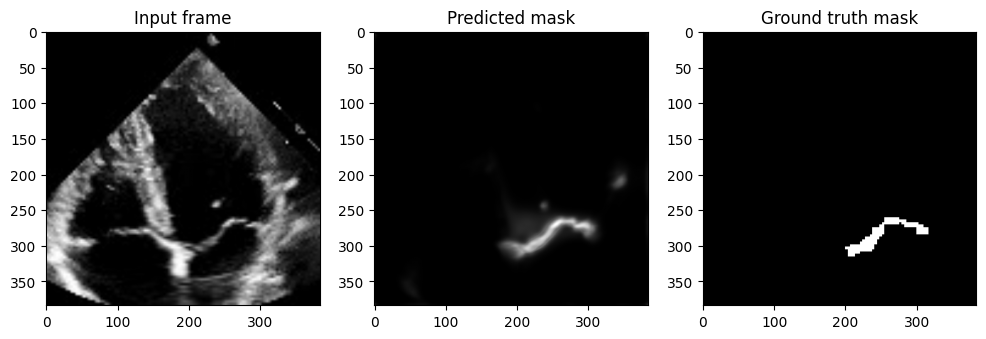

In [35]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()

frame, mask = train_dataset[0]     # frame: (1, H, W)
frame_in = frame.unsqueeze(0)      # (1, 1, H, W)

with torch.no_grad():
    pred = model(frame_in)         # raw logits
    pred = torch.sigmoid(pred)     # convert to probability 0–1
    pred = pred.squeeze().cpu()    # remove batch/channel dims

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(frame.squeeze(), cmap='gray')
plt.title("Input frame")

plt.subplot(1,3,2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted mask")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Ground truth mask")

plt.show()


In [40]:
def threshold_mask(pred, threshold=0.3):
    # Ensure pred is squeezed, detached, and on CPU
    pred = pred.squeeze().detach().cpu()
    binary_mask = (pred > threshold).float()

    return binary_mask


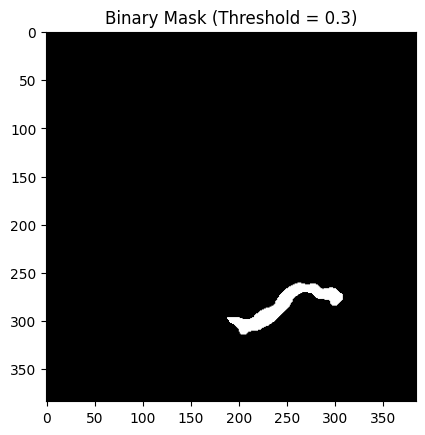

In [41]:
with torch.no_grad():
    pred = model(frame_in)
    pred = torch.sigmoid(pred)
    pred = pred.squeeze()  # HxW

binary_mask = threshold_mask(pred, threshold=0.3)

plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask (Threshold = 0.3)")
plt.show()



# TESTING

In [ ]:
def threshold_mask(pred, threshold=0.3):
    pred = pred.squeeze().detach().cpu()
    return (pred > threshold).float()

all_binary_masks = []

model.eval()
with torch.no_grad():
    for frames, masks in train_loader:
        logits = model(frames)
        probs  = torch.sigmoid(logits)

        for i in range(probs.size(0)):
            bin_mask = threshold_mask(probs[i], threshold=0.3)
            all_binary_masks.append(bin_mask)


In [ ]:
import torch
import torch.nn.functional as F

def threshold_mask(pred, threshold=0.3):
    pred = pred.squeeze().detach().cpu()
    return (pred > threshold).float()

def compute_iou(pred, true):
    """
    pred, true: binary masks with values in {0,1}, shape (H, W)
    """
    pred = pred.bool()
    true = true.bool()
    
    intersection = (pred & true).sum().item()
    union = (pred | true).sum().item()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # perfect empty mask case

    return intersection / union


def compute_dice(pred, true):
    pred = pred.bool()
    true = true.bool()

    intersection = (pred & true).sum().item()
    total = pred.sum().item() + true.sum().item()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0

    return 2 * intersection / total


def evaluate_model(model, dataloader, threshold=0.3):
    model.eval()

    results = []
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for frames, masks in dataloader:

            # Forward
            logits = model(frames)
            probs  = torch.sigmoid(logits)

            # Per-sample evaluation
            for f, m, p in zip(frames, masks, probs):
                binary = threshold_mask(p, threshold)

                # Ground truth must be binary
                true_mask = (m.squeeze().cpu() > 0.5).float()

                iou  = compute_iou(binary, true_mask)
                dice = compute_dice(binary, true_mask)

                iou_scores.append(iou)
                dice_scores.append(dice)

                results.append({
                    "frame": f.cpu(),
                    "mask": true_mask,
                    "pred_prob": p.squeeze().cpu(),
                    "binary": binary,
                    "iou": iou,
                    "dice": dice
                })

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    return results, avg_iou, avg_dice


In [43]:
results, avg_iou, avg_dice = evaluate_model(model, train_loader, threshold=0.3)

print("Average IoU:", avg_iou)
print("Average Dice:", avg_dice)


Average IoU: 0.5876050263092842
Average Dice: 0.7334022906909008


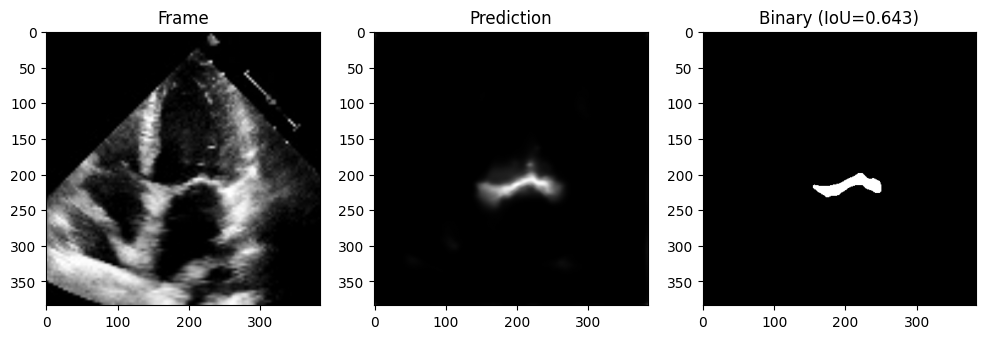

In [44]:
import matplotlib.pyplot as plt

sample = results[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample["frame"].squeeze(), cmap='gray'); plt.title("Frame")
plt.subplot(1,3,2); plt.imshow(sample["pred_prob"], cmap='gray'); plt.title("Prediction")
plt.subplot(1,3,3); plt.imshow(sample["binary"], cmap='gray'); plt.title(f"Binary (IoU={sample['iou']:.3f})")
plt.show()
